In [605]:
import pandas as pd
#import requests
#from bs4 import BeautifulSoup as bs
import selenium
import ssl
import urllib3
from datetime import datetime
import matplotlib.pyplot as plt

import numpy as np


from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys

from selenium.webdriver.common.action_chains import ActionChains

from selenium.webdriver.support.ui import Select
import time

## Functions

In [259]:
def start_driver(url):
    driver = webdriver.Edge()
    driver.get(url)
    
    # Wait until the page is fully loaded
    wait = WebDriverWait(driver, 100)  # Adjust the timeout value as needed
    wait.until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
    return driver

In [267]:
def player_search(driver, player_str):
    # Search for Player
    search_bar_xpath = '//input[@id="search-for-players"]'
    search_bar_element = driver.find_element(By.XPATH, search_bar_xpath)
    search_bar_element.send_keys(player_str)
    search_bar_element.send_keys(Keys.RETURN)
    wait = WebDriverWait(driver, 100)
    wait.until(EC.presence_of_element_located((By.TAG_NAME, 'body')))

In [274]:
def change_game_log_year(driver, year):
    # Change Year of Game Log
    selected_tab_xpath = '//div[@class="filter-tab is-selected"]'
    selected_tab_element = driver.find_element(By.XPATH, selected_tab_xpath)
    if selected_tab_element.text != str(year):  
        year_tabs_xpath = '//div[@class="filter-tab"]'
        year_tabs_elements = driver.find_elements(By.XPATH, year_tabs_xpath)
        chosen_year_xpath = f'//div[@data-name="{str(year)}"]'
        for element in year_tabs_elements:
            if element.text == str(year):
                selected_tab_element = element
                break
                
    driver.execute_script("arguments[0].scrollIntoView();", selected_tab_element)
    selected_tab_element.click()
    #search_bar_element.send_keys(player_str)
    #search_bar_element.send_keys(Keys.RETURN)
    #wait.until(EC.presence_of_element_located((By.TAG_NAME, 'body')))

In [680]:
def get_game_log_table(driver):
    # Find Game Log Table
    table_xpath = f'//div[@id="gamelog-{str(year)}-stats"]'
    game_log_element = driver.find_element(By.XPATH, table_xpath)
    table_xpath = './/div[@role="grid"]'
    wait = WebDriverWait(driver, 100)  # Adjust the timeout value as needed
    wait.until(EC.presence_of_element_located((By.XPATH, table_xpath)))
    game_log_element = game_log_element.find_element(By.XPATH, table_xpath)
    return game_log_element

In [603]:
def scroll_left(game_log_element):
    scrollable_xpath = './/div[@role="scrollbar"]'
    scrollable_element = game_log_element.find_element(By.XPATH, scrollable_xpath)
    
    # Scroll the element to the left using JavaScript
    #driver.execute_script("arguments[0].scrollIntoView();", scrollable_element)
    driver.execute_script("arguments[0].scrollLeft -= 500;", scrollable_element)

def scroll_right(game_log_element):
    scrollable_xpath = './/div[@role="scrollbar"]'
    scrollable_element = game_log_element.find_element(By.XPATH, scrollable_xpath)
    
    # Scroll the element to the right using JavaScript
    #driver.execute_script("arguments[0].scrollIntoView();", scrollable_element)
    driver.execute_script("arguments[0].scrollLeft += 500;", scrollable_element)

In [831]:
def get_game_log_header(game_log_element):
    #header_xpath = './/div[@class="webix_ss_center"]'
    #header_element = game_log_element.find_element(By.XPATH, header_xpath)
    header_rows = game_log_element.find_elements(By.XPATH, './/tr[@section="header" and @role="row"]')
    header_cells_top = header_rows[2].find_elements(By.XPATH,'.//td[@column]')
    header_cells_bottom = header_rows[3].find_elements(By.XPATH,'.//td[@column]')

    header_top_list = []
    header_top_col_nums = []
    for cell in header_cells_top:
        if len(cell.text.strip()) > 0:
            header_top_list.append(cell.text.strip())
            header_top_col_nums.append(int(cell.get_attribute("column")))

    
    header_top_df = pd.DataFrame(dict(col_nums=header_top_col_nums, col_names=header_top_list)).set_index('col_nums')
    header_top_df = header_top_df[::-1]
    #display(header_top_df)
    
    header_list = []
    header_col_nums = []
    header_number = header_top_col_nums[-1]
    for cell in header_cells_bottom[::-1]:
        i = int(cell.get_attribute("column"))
        #print(i)
        if len(cell.text.strip()) > 0:
            if i in header_top_col_nums:
                header_number = i
                #print(header_number)
            new_header = (header_top_df.loc[header_number][0], cell.text.strip())
            #print(new_header)
            header_list.append(new_header)
            header_col_nums.append(i)

    first_two_headers = [('Games', 'Week'), ('Games', 'Opponent')]
    
    header_list = first_two_headers + header_list[::-1]
    header_col_nums = [0, 1] + header_col_nums[::-1]
    #print(header_list)
    #print(header_col_nums)
    
    return pd.DataFrame(dict(col_num = header_col_nums, col_names = header_list))

In [829]:
def get_dnp_weeks(game_log_element):
    # Get the index of the row with 'BYE'
    game_columns = game_log_element.find_element(By.XPATH, './/div[@column="1"]').text.split('\n')
    #print(game_columns)
    bye_index = game_columns.index('BYE')
    # Get index of other weeks where they didn't play
    snap_column = game_log_element.find_element(By.XPATH, './/div[@column="4"]').text.split('\n')
    snap_column.insert(bye_index, 'BYE')
    #print(snap_column)
    dnp_weeks = [i for i, x in enumerate(snap_column) if x == 'DNP']
    dnp_weeks.append(bye_index)
    dnp_weeks.sort()
    #print(dnp_weeks)
    return dnp_weeks

In [825]:
def get_game_log_data(game_log_element, col_names, year, dnp_weeks):
    col_names = col_names.set_index('col_num')
    bye_index = None
    columns_xpath = './/div[@column]'
    columns_elements = game_log_element.find_elements(By.XPATH, columns_xpath)
    
    
    #cells_xpath = './/div[@role="gridcell"]'
    df = pd.DataFrame()
    
    
    for column in columns_elements:
        #column_list = []
        #gridcell_elements = game_log_element.find_elements(By.XPATH, cells_xpath)
        #for cell in gridcell_elements:
        #    column_list.append(cell.text)
        # Get text for column
        i = int(column.get_attribute("column"))
        tmp = column.text
        tmp = tmp.split('\n')
        tmp = [x for x in tmp if x != 'DNP']


        # Delete on DNP rows:
        if i >= 1:
            if len(tmp) > len(df):
                for index in dnp_weeks[::-1]:
                    del tmp[int(index)]

        # Get rid of bye week row if column includes it
        #if bye_index:
        #    if len(tmp) > len(df):
        #        if len(tmp) != 0:
        #             tmp = tmp.drop(bye_index)

        # Add column to main dataframe
        if i == 0:
            df[('Games','Year')] = [year] * len(tmp)
        df[col_names.loc[i][0]] = pd.Series(tmp)

        # Remove bye row and find bye index
        #if i == 1:
        #    rows_with_bye = df[df[col_names[i]].str.contains('BYE')]

            # Get the index of the row with 'BYE'
        #    bye_index = rows_with_bye.index.tolist()[0]

            # Delete BYE row
        #    df = df[~df[col_names[i]].str.contains('BYE')].reset_index(drop = True)
        if i == 1:
            df = df.drop(dnp_weeks).reset_index(drop=True)

    df.columns = pd.MultiIndex.from_tuples(df.columns)
    return df



## Get Data

In [873]:
rotowire_url = f'https://www.rotowire.com/'
player_str = 'Travis Kelce'
year = 2023

driver = start_driver(rotowire_url)
player_search(driver, player_str)

In [874]:
all_games_df = pd.DataFrame()
for year in [2016,2017,2018,2019,2020,2021,2022, 2023,2024]:
    print(year)
    change_game_log_year(driver, year)
    game_log_element = get_game_log_table(driver)
    time.sleep(1)
    scroll_left(game_log_element)
    time.sleep(1)
    headers = get_game_log_header(game_log_element)
    dnp_weeks = get_dnp_weeks(game_log_element)
    game_log_df = get_game_log_data(game_log_element, headers, year, dnp_weeks)
    time.sleep(1)
    scroll_right(game_log_element)
    time.sleep(1)
    headers_2 = get_game_log_header(game_log_element)
    game_log_df_2 = get_game_log_data(game_log_element, headers_2, year, dnp_weeks)
    game_log_df_2 = game_log_df_2.drop(list(set(game_log_df.columns).intersection(set(game_log_df_2.columns))), axis = 1)
    game_log_df_combined = pd.concat([game_log_df, game_log_df_2], axis=1).fillna(0)
    game_log_df_combined[('Games','Year')] = year
    all_games_df = pd.concat([all_games_df, game_log_df_combined]).reset_index(drop = True)

driver.close()


ypc_col = all_games_df[('Rushing', 'YDS')].astype(int) / all_games_df[('Rushing', 'ATT')].astype(int)
ypc_col_index = all_games_df.columns.get_loc(('Rushing', 'ATT')) + 1
all_games_df.insert(ypc_col_index, [('Rushing', 'YPC')], ypc_col)

2016
2017
2018
2019
2020
2021
2022
2023
2024


TypeError: unhashable type: 'list'

In [910]:
all_games_df[(all_games_df.Games.Year == last_game_played[0]) & (all_games_df.Games.Week == str(last_game_played[1]))]

Games               Opp Rank Fantasy Snaps    Receiving         ...  \
     Year Week Opponent    vs TE  Points   OFF ST       REC YDS TD  ...   
145  2024    2      CIN       13     0.6    53  0         1   5  0  ...   

    Red Zone Rushes Rec Distance         Kick Ret    Punt Ret    Fumbles       
                IN5          AVG 20+ 40+      Yds TD      Yds TD     TOT LOST  
145               1          5.0   0   0        0  0        0  0       0    0  

[1 rows x 33 columns]

In [912]:
last_game_played = [2024, 2]
cutoff_index = all_games_df[(all_games_df.Games.Year == last_game_played[0]) & (all_games_df.Games.Week == str(last_game_played[1]))].index[0]
past_games_df = all_games_df[:cutoff_index+1]

## Analysis

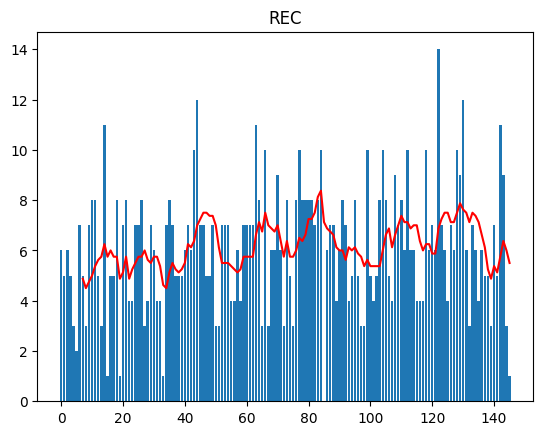

In [921]:
selected_column = ('Receiving', 'REC')

def get_moving_avg(series, window):
    return series.rolling(window).mean()

moving_avg = get_moving_avg(past_games_df[selected_column], 8)

plt.bar(past_games_df.index, past_games_df[selected_column].astype(float))
plt.plot(past_games_df.index, moving_avg, color = 'red')
plt.title(selected_column[1])
plt.show()